<a href="https://colab.research.google.com/github/DDD26/tum-adlr-ws20-02/blob/main/RI%20demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### install stable-baseline3 package ###
!pip install stable-baselines3[extra]
!apt-get install ffmpeg freeglut3-dev xvfb

     |████████████████████████████████| 153kB 5.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Err:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7
  404  Not Found [IP: 91.189.88.152 80]
E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubuntu4.7_amd64.deb  404  Not Found [IP: 91.189.88.152 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [ ]:
### import ###
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import torch
import gym
from gym import spaces
from stable_baselines3 import PPO, A2C, SAC # DQN coming soon
from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/cmd_util.py:6: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  "Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.", FutureWarning


In [ ]:
### define our robot environment ###
class Environment():
    def __init__(self, pos, size, bound, voxel_size = np.array([0.1,0.1]), eps=1, order=1):
        """
        Args: 
            pos: np array with shape [N,2], with N being number of obstacles, indicating coordinate of obstacle'slower left corner
            size: np array with shape [N,2], with N being number of obstacles, indicating width and hight of obstacles
            bound: np array with shape [2,], upper boundary of the work space. Lower bound is implicitly (0,0)
            voxel_size: np array with shape [2,], voxel_size in x and y direction
            eps: scalar, parameter in cost function
            order: positive int, interpolation order
        """
        self.pos = pos.astype(int)
        self.size = size.astype(int)
        self.bound = bound.astype(int)
        self.voxel_size = voxel_size
        self.ob_num = pos.shape[0]
        self.eps = eps
        self.order = order 
        
        self.obstacle = self.obstacle()
        self.dis = self.dis() 
        self.dis_der = self.dis_der()
        self.dis_fun = self.dis_fun1()
        self.dis_der_fun = self.dis_der_fun1()
        self.cost_fun = self.cost_fun1()
        self.cost_der_fun = self.cost_der_fun1()
                
    def obstacle(self):
        """
        Geometric shape of the environment 
        Returns: 
            obstacle: a boolean numpy array with shape [bound[0],bound[1]], True indicates obstacle, False indicates free 
        """
        pos = self.pos
        size = self.size 
        bound = self.bound
        obstacle = np.zeros(bound,dtype = bool)
        for i in range(pos.shape[0]):
            low_left = pos[i]
            up_right = low_left + size[i]
            obstacle[tuple(map(slice, low_left, up_right))] = True
        return obstacle 
    
    def dis(self):
        """
        Create nearest distance field, negative indicates inside obstacle
        Returns: 
            dis: a float numpy array with shape [bound[0],bound[1]]
        """
        bound = self.bound
        voxel_size = self.voxel_size 
        
        im = self.obstacle
            
        pad = np.ones(self.bound+2, dtype=bool)
        pad[1:bound[0]+1,1:bound[1]+1] = im    
            
        dis = ndimage.distance_transform_edt(-pad.astype(int) + 1, sampling=voxel_size)
        dis1 = ndimage.distance_transform_edt(pad.astype(int), sampling=voxel_size)
        dis[pad] = - dis1[pad]  # Add interior information
            
        dis = dis[1:bound[0]+1,1:bound[1]+1]
        return dis
    
    def dis_der(self):
        """
        Applying sobel filter to nearest distance field to get and x and y gradient field 
        Returns: 
            dis_der: a float numpy array with shape [2,bound[0],bound[1]], dis_der[0] x gradient and dis_der[1] y gradient 
        """
        dis_der = np.zeros((2,self.bound[0],self.bound[1]),dtype=np.float64)
        for d in range(2):  # Treat image boundary like obstacle
            dis_der[d, ...] = ndimage.sobel(self.dis, axis=d, mode='constant', cval=0)/self.voxel_size[d]
        return dis_der
    
    def dis_fun1(self):
        """
        Interpolate the nearest distance to get distance function
        Returns: 
            dis_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                      output is float numpy array with shape [N,], respecting cost of each inquiry points
        """ 
        factor = 1/self.voxel_size
        im = self.dis
        def dis_fun(x):
            x = np.multiply(x,factor)-0.5
            out = ndimage.map_coordinates(im, coordinates=x.T, order=self.order, mode='nearest')
            return out          
        return dis_fun
    
    def dis_der_fun1(self):
        """
        Interpolate the x and y gradient field to get distance gradient function
        Returns: 
            dis_der_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                          output is float numpy array with shape [N,2], respecting x and y gradient of each point
        """ 
        der = self.dis_der
        factor = 1/self.voxel_size
        def dis_der_fun(x):
            x = np.multiply(x,factor)-0.5
            gx = ndimage.map_coordinates(der[0,...], coordinates=x.T, order=self.order, mode='nearest')
            gy = ndimage.map_coordinates(der[1,...], coordinates=x.T, order=self.order, mode='nearest')
            return np.stack((gx,gy),axis=0).T
        return dis_der_fun
    
    def cost_fun1(self):
        """
        Assign cost to nearest distance field
        Returns: 
            cost_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                       output is float numpy array with shape [N,], cost of each point
        """
        eps = self.eps
        def cost_fun(x):
            dis = self.dis_fun(x)
            cost = np.zeros(dis.shape,dtype=np.float64)
            cost[dis>eps] = 0
            cost[np.logical_and(dis>0,dis<=eps)] = np.square(dis[np.logical_and(dis>0,dis<=eps)]-eps)/(2*eps)
            cost[dis<=0] = eps/2 - dis[dis<=0]
            return cost
        return cost_fun

    def cost_der_fun1(self):
        """
        Assign cost gradient
        Returns: 
            cost_der_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                           output is float numpy array with shape [N,2], x and y cost gradient of each point
        """
        eps = self.eps
        def cost_der_fun(x):
            dis = self.dis_fun(x)
            dis_der = self.dis_der_fun(x)
            der = cost = np.zeros((len(dis),2),dtype=np.float64)
            der[dis>eps] = 0
            der[np.logical_and(dis>0,dis<=eps)] = np.multiply((dis[np.logical_and(dis>0,dis<=eps)]-eps),dis_der[np.logical_and(dis>0,dis<=eps)].T).T/eps
            der[dis<=0] = - dis_der[dis<0]
            return der 
        return cost_der_fun
 
class Objective():
    def __init__(self,start, end, opt_num, sp_num,co_num, environment,w):
        """
        Args: 
            start: np array with shape [2,], start point coordinate of the robot
            end: np: array with shape [2,], end point coordinate of the robot
            opt_num: number of optimization points 
            sp_num: number of subsampling points on line segements between two optimization points for calculating objective
            co_num: number of subsampling points on line segements between two optimization points for collision check
            environment: environment the objective function based on
            w: weight term for length objective 
        """
        self.start = start 
        self.end = end
        self.opt_num = opt_num 
        self.sp_num = sp_num
        self.co_num = co_num
        self.environment = environment
        self.w = w  #length weight 
        
        self.ob_fun = self.ob_fun1()
        self.ob_der_fun = self.ob_der_fun1()
        
        
    def ob_fun1(self):
        """
        Given a trajectory, calculate its obstacle cost and length cost and objective 
        Returns: 
            ob_fun: a function whose input is float numpy array with shape [opt_num, 2]
                                     output is float numpy scalar, the objective value
        """
        env = self.environment
        w = self.w
        start = self.start
        end = self.end
        def ob_fun(x):
            x1 = self.all_points(x,self.sp_num)
            x1 = np.delete(x1,0,0)
            x1 = np.delete(x1,x1.shape[0]-1,0)
            return np.mean(env.cost_fun(x1)) + w*np.sum(np.diff(np.insert(x,(0,x.shape[0]),(start,end),axis=0),axis=0)**2)
        return ob_fun
    
    def ob_der_fun1(self):
        """
        Derivative of objective function
        Returns: 
            ob_der_fun: a function whose input is a float numpy array with shape [opt_num, 2]
                                         output is a float numpy array with shape [opt_num,2], the derivative 
        """
        env = self.environment
        w = self.w
        opt_num = self.opt_num
        sp_num = self.sp_num
        def ob_der_fun(x):
            ### gradient of obstacle cost ###
            x1 = self.all_points(x,self.sp_num)
            x1 = np.delete(x1,0,0)
            x1 = np.delete(x1,x1.shape[0]-1,0)
            x1 = self.environment.cost_der_fun(x1)
            x1 = torch.Tensor(x1).reshape(1,1,x1.shape[0],x1.shape[1])
            kernel1 = np.append(np.arange(1,sp_num+2,1),np.arange(sp_num,0,-1))/(sp_num+1)
            kernel1 = torch.Tensor(kernel1).reshape(1,1,kernel1.shape[0],1)
            re1 = torch.nn.functional.conv2d(x1,kernel1,stride=(sp_num+1,1))
            re1 = re1/(opt_num+(opt_num+1)*sp_num)
            re1 = torch.squeeze(torch.squeeze(re1,0),0).numpy()
            ### gradient of length cost ###
            x2 = np.insert(x,(0,x.shape[0]),(start,end),axis=0)
            x2 = torch.Tensor(x2).reshape(1,1,x2.shape[0],x2.shape[1])
            kernel2 = torch.Tensor([-1,2,-1]).reshape(1,1,3,1)
            re2 = 2*w*torch.nn.functional.conv2d(x2,kernel2,stride=1)
            re2 = torch.squeeze(torch.squeeze(re2,0),0).numpy()
            return re1+re2
        return ob_der_fun
    
    def all_points(self,x,num):
        """
        Combine all start, end, optimization and subsampling points (both for calculating objective and collision check)
        Args:
            x: float numpy array with shape [opt_num,2], optimization points
            num: number of subsampling points
        Returns: 
            x1: float numpy array with shape [opt_num+2+num*(opt_num+1), 2]
        """
        start = self.start 
        end = self.end 
        x1 = np.insert(x,(0,x.shape[0]),(start,end),axis=0)
        for i in range(x1.shape[0]-1):
            x2 = np.linspace(x1[i+(num)*i],x1[i+1+(num)*i],num+1,endpoint=False)
            x2 = np.delete(x2,0,0)
            x1 = np.insert(x1,i+1+(num)*i,x2,axis=0)
        return x1
    
    def initial(self):
        """
        Initialize the trajectory by connecting start, end point and uniform sampling along this line segment
        Returns: 
            x0: float numpy array with shape [opt_num, 2], initial optimization points
        """
        x0 = np.linspace(self.start,self.end,self.opt_num+1,endpoint=False)
        x0 = np.delete(x0,0,0)
        return x0

    def collision(self,x):
        """
        Check if any of optimization and subsampling points collides with any of the obstacles. Moreover check if all points are in the boundary. 
        If both conditions are satisfied, returns True, otherwise False.    
        """
        low = self.environment.pos
        high = self.environment.pos + self.environment.size
        x1 = self.all_points(x,self.co_num)
        factor = 1/self.environment.voxel_size
        x1 = np.multiply(x1,factor)-0.5
        out = np.empty((x1.shape[0],),dtype=bool)
        for i in range(x1.shape[0]):
            k = np.concatenate((x1[i]>low,x1[i]<high),axis=1)
            k = np.all(k,axis=1)
            out[i] = np.any(k)
            out1 = np.any(out)
            out2 = np.all([x1>0,x1<self.environment.bound])
        return not out1 and out2

In [ ]:
### setup reinforcement learning environment ###
class MPEnv(gym.Env):
    def __init__(self,objective):
        """
        Args: 
            objective: Objective object that the reinforcement learning framework is based on  
        """
        super(MPEnv, self).__init__()
        self.obj = objective                                                                                     # objective function that RI is based on
        self.environment = self.obj.environment                                                                  # robot environment that RI is based on
        self.at_space_dim = self.obj.opt_num*2                                                                   # action space dimension
        self.action_space = spaces.Box(low = -10, high = 10, shape=(self.at_space_dim,),dtype=np.float32)      
        self.history_num = 1                                                                                     # how many historical trajectory does the observation based on
        self.warp_dim = 2*self.obj.opt_num                                                                       # dimension of observation that generated from one historical trajectory, 
                                                                                                                 # now we consider only gradient for easier training, 
                                                                                                                 #in future we can add objective value and coordinate
        self.ob_space_dim = self.history_num*self.warp_dim                                                       # total dimension of observation space, start, end point coordinate not included,
                                                                                                                 # may add that in future
        self.observation_space = spaces.Box(low=-40, high = 40, shape=(self.ob_space_dim,), dtype=np.float32)
        self.pos = self.obj.initial()                                                                            # coordinate of the trajectory with shape [opt_num, 2], the state for RI
        self.observation = None

    def reset(self):
        """
        initialize the trajectory, return the observation initial state     
        """
        self.pos = self.obj.initial()
        start = self.obj.start
        end = self.obj.end
        initial_der = self.obj.ob_der_fun(self.pos).flatten()
        initial_ob_val = np.array([self.obj.ob_fun(x0)])                                   # not used if history_num == 1
        history = np.zeros((self.history_num-1)*(1+4*self.obj.opt_num),dtype=np.float32)   # not used if history_num == 1
        self.observation = np.concatenate((history,initial_der),axis=0).astype(np.float32)
        return self.observation
    
    def step(self, action):
        """
        Conduct the given action, go to the next state and return new observation, immdiate reward, additional info and check if goal is reached
        PS: done is actually useless for training, because reward is not depend on done, unlike other RI cases
        """
        self.pos = self.pos + action.reshape(self.obj.opt_num,2)
        self.pos = np.clip(self.pos,0,self.environment.bound*self.environment.voxel_size)

        new_observation = obj.ob_der_fun(self.pos).flatten()
        self.observation = np.delete(self.observation,range(0, self.warp_dim)) # not used if history_num == 1 
        self.observation = np.concatenate((self.observation,new_observation),axis=0).astype(np.float32)  # not used if history_num == 1
        done = bool(self.obj.collision(self.pos))
        reward = -self.obj.ob_fun(self.pos)
        info = {}
        return self.observation, reward, done, info

    def close(self):
        pass

True
cost= 1.684025889024842
[[17.85976795  4.73879648]
 [34.55897202  6.17323945]
 [42.22355162 18.97576142]
 [48.28911555 31.86560151]
 [54.18445807 45.0084291 ]]


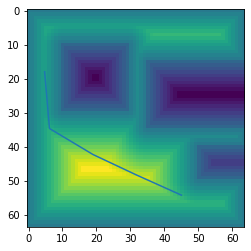

In [ ]:
### gradient descent demo ###

## all input of robot environment ## 
pos = np.array([[10,10],[40,50],[15,35]])
size = np.array([[20,20],[10,30],[20,30]])
bound = np.array([64,64])
start = np.array([0.1,0.1])
end = np.array([6.3,6.3])
opt_num = 5
sp_num = 5
co_num = 20
w = 0.1
environment = Environment(pos,size,bound)
obj = Objective(start, end, opt_num, sp_num, co_num, environment, w)
ob_fun = obj.ob_fun
ob_der_fun = obj.ob_der_fun
## all input of robot environment ##

## gradient descent ##
iter_num = 200
lr = 0.2
x0 = obj.initial()

for i in range(iter_num):
    x0 = x0 - lr*ob_der_fun(x0)
    # print(x0) # 
b = environment.dis
plt.imshow(b)
print(obj.collision(x0))
print("cost=",obj.ob_fun(x0))
x0 = x0*10-0.5
print(x0)
plt.plot(x0[:,1],x0[:,0])
## gradient descent ##

In [ ]:
### reinforcement demo -- training ###
env = MPEnv(obj)
check_env(env, warn=True)
model = PPO('MlpPolicy', env, gamma=1, verbose=1).learn(10000)

/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/env_checker.py:232: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


Using cpu device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 137  |
|    iterations      | 1    |
|    time_elapsed    | 14   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013005665 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | -1.3e+04    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.92e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0261     |
|    std                  | 0.999       |
|    value_loss         

initial cost= 1.7575723518825996
initial location [[1.13333333 1.13333333]
 [2.16666667 2.16666667]
 [3.2        3.2       ]
 [4.23333333 4.23333333]
 [5.26666667 5.26666667]]
step= 0 False 1.7516772354327639
step= 1 False 1.802172612957711
step= 2 False 1.8512662616594755
step= 3 False 1.8801821467943953
step= 4 False 1.9056610177576747
step= 5 False 1.9284724565500384
step= 6 False 1.9479126398468118
step= 7 False 1.9619266620372784
step= 8 False 1.9742845498295902
step= 9 False 1.9887910226489498
step= 10 False 2.006602188497394
step= 11 False 2.0280320663451263
step= 12 False 2.0539503285417764
step= 13 False 2.082497869622271
step= 14 False 2.112637110506115
step= 15 False 2.1427681886770746
step= 16 False 2.171385722277777
step= 17 False 2.2002299584472182
step= 18 False 2.230003933582253
step= 19 False 2.259643811039273
step= 20 False 2.2898043045878334
step= 21 False 2.319964576630618
step= 22 False 2.3496323441287577
step= 23 False 2.3778642833510117
step= 24 False 2.406580561

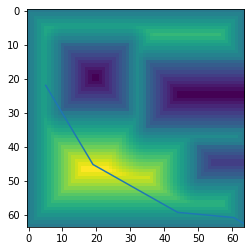

In [ ]:
### reinforcement learning demo -- test ###
obs = env.reset()
# env.pos = 6.4*np.random.rand(env.obj.opt_num,2)    # this two lines enables different initialization at test time 
# obs = env.obj.ob_der_fun(env.pos).flatten()        # this two lines enables different initialization at test time 
print("initial cost=",env.obj.ob_fun(env.pos))
print("initial location",env.pos)
n_steps = 200
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  print("step=",step,env.obj.collision(env.pos),env.obj.ob_fun(env.pos))
  if done:
    print("Goal reached!", "reward=", reward,"step=",step)
    break
x = env.pos
plt.imshow(environment.dis)
x = x*10-0.5
print(x)
plt.plot(x.T[1],x.T[0])

Conclusion: 
1. PPO is more promising than A2C and SAC because with 1000 iteration training, PPO is able to find collision free path very stably.
2. The default environment is relative simple, if additional obstacle with pos=[35,5] size = [30,20] is added, 1000 iteration PPO doesn't work while gradient descent can find feasible solution
3. Although PPO agent can find feasible solution, if we let the agent further conduct its policy, the solution maybe infeasible again. However, if the objective function is 10 dim quadratic function, agent just oscillate in neighborhood of 0.
4. Feasible solution found by PPO agent normally has a high cost.
5. Pure reinforcement learning is only suitable for low dimensional optimization problem